# Klusterointi ja assosiaatio

## Tavoitteet
Tavoite tässä prosessissa on optimoida drooneja käyttävän kuljetusyrityksen toimintaa löytämällä optimaalisia sijainteja droonikeskuksille. Yritys haluaa myös suositella asiakkaille tuotteita heidän ostoshistoriansa perusteella, joten datasta halutaan löytää kiinnostavia yhteyksiä eri tuoteryhmien välillä. 

## Datan kuvaus
Käytössä on 2 eri datasettiä: 
- Asiakkaiden sijannit, joka pitää sisällään seuraavat sarakkeet:
- - clientid: Asiakkaan oma tunniste
- - x: Asiakkaan sijainnin x-kordinaatti
- - y: Asiakkaan sijainnin y-kordinaatti
- Tuotteiden myyntidata, joka pitää sisällään seuraavat sarakkeet:
- - ID: Ostotapahtuman tunniste
- - Prod1-Prod20: Binääriarvo, joka kertoo ostettiinko tietystä tuoteryhmästä tuote vai ei arvoilla yksi (1) tai nolla (0).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_cust = pd.read_csv('drone_cust_locations.csv')
df_prod = pd.read_csv('drone_prod_groups.csv')

## Osa 1: Klusterointi

Otetaan pieni näyte datasetin sisällöstä. Datasetti ei ole kovin monimutkainen, joten siinä ei pitäisi löytyä paljoa puuttuvia arvoja.

In [3]:
df_cust.head()

,clientid;x;y
0,1;622.7715723;164.8576227
1,2;416.3572979;630.1936343
2,3;292.7350197;567.3332306
3,4;737.2112881;166.2256759
4,5;540.4753747;682.912298


### Datan visualisointi
Visualisoidaan asiakkaiden sijainnit:
Tämä visualisointi auttaa meitä ymmärtämään asiakkaiden maantieteellistä jakaumaa.

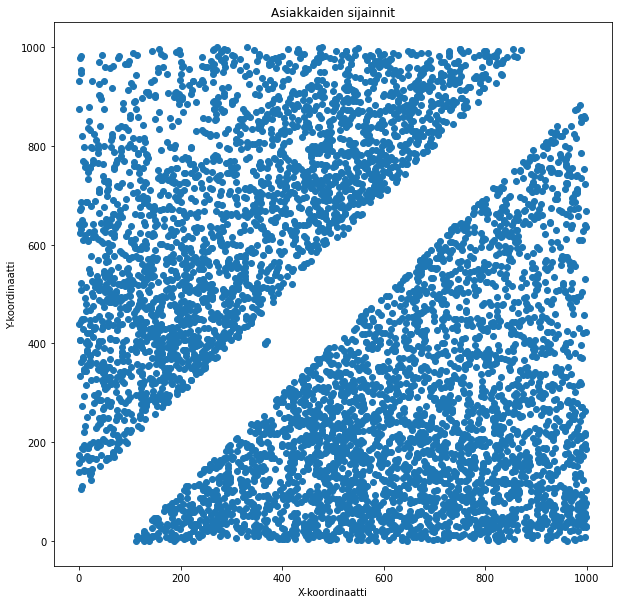

In [4]:
# Load the data and split the columns
df_cust = pd.read_csv('drone_cust_locations.csv', sep=';', header=None, names=['clientid', 'x', 'y'])

# Convert x and y to numeric, just in case
df_cust['x'] = pd.to_numeric(df_cust['x'], errors='coerce')
df_cust['y'] = pd.to_numeric(df_cust['y'], errors='coerce')

# Create the scatter plot
plt.figure(figsize=(10,10))
plt.scatter(df_cust['x'], df_cust['y'])
plt.title('Asiakkaiden sijainnit')
plt.xlabel('X-koordinaatti')
plt.ylabel('Y-koordinaatti')
plt.show()

### Datan esikäsittely
Dataa ei tarvitse tässä vaiheessa normalisoida, koska tutkimme vain kordinaattiarvoja, jotka ovat jo samassa skaalassa. 

### Mallinnus

### Arviointi

## Osa 2: Assosiaatio

### Datan ymmärtäminen

### Datan esikäsittely

### Mallinnus

### Arviointi

## Käyttöönotto
Yritys voisi käyttää käsittelystä johdettuja optimaalisia droonikeskuksen sijainteja uusien droonikeskusten sijaintien valintaan. Tuotteiden ostotapahtumien väliset yhteydet voisi suoraan implementoida yrityksen verkkosivuille/sovellukseen antamaan asiakkaille suosituksia, kun hän selailee kauppaa. 